<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Exploratory Data Analysis - On Transmission Statistics/Insights
</p>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
#  Load dataset
csv_path = '../all_data_files/visually_cleaned_df.csv'
df = pd.read_csv(csv_path, low_memory=False)

# Parse timestamp
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(['device_id','time']).reset_index(drop=True)

#  Drop rows with missing counters
df = df.dropna(subset=['p_count','f_count'])

# Convert to integers
df['f_count'] = df['f_count'].astype(int)
df['p_count'] = df['p_count'].astype(int)

# Overall PDR per device
pdr_dev = (
    df
    .groupby('device_id')
    .agg(
        total_sent=('p_count','max'),
        total_recv=('f_count','max')
    )
    .assign(pdr=lambda x: x['total_recv']/x['total_sent']*100)
    .reset_index()
)
print("\nOverall PDR per device (%):\n\n", pdr_dev)


Overall PDR per device (%):

   device_id  total_sent  total_recv        pdr
0       ED0      183560      165606  90.219002
1       ED1      330438      294070  88.994002
2       ED2      330489      297425  89.995431
3       ED3      218544      195762  89.575555
4       ED4      330450      294628  89.159631
5       ED5      330570      302726  91.576973


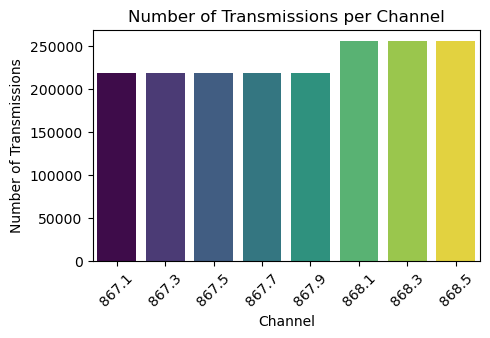

In [4]:
# Count transmissions per channel
channel_counts = df['frequency'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(5, 3))
sns.barplot(
    x=channel_counts.index,
    y=channel_counts.values,
    hue=channel_counts.index,      # 'x' to 'hue'
    palette='viridis',
    dodge=False,                  
    legend=False              
)
plt.title('Number of Transmissions per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Transmissions')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Count how many packets each device sent at each SF
counts = (
    df
    .groupby(['device_id','SF'], observed=True)
    .size()
    .reset_index(name='count')
)

# For convenience, the full list of SFs and devices
sfs     = sorted(df['SF'].unique())
devices = df['device_id'].unique()

# Look at the table
pivot = counts.pivot(index='device_id', columns='SF', values='count').fillna(0).astype(int)
pivot

SF,7,8,9,10,11,12
device_id,,,,,,
ED0,57619,57211,55062,52511,43554,44738
ED1,57533,56791,54175,51196,42478,44133
ED2,57932,57624,55486,52788,43407,44382
ED3,57468,57016,54305,51668,43108,44242
ED4,57604,56971,54226,51036,42605,44147
ED5,58155,58309,57145,56479,45039,45186


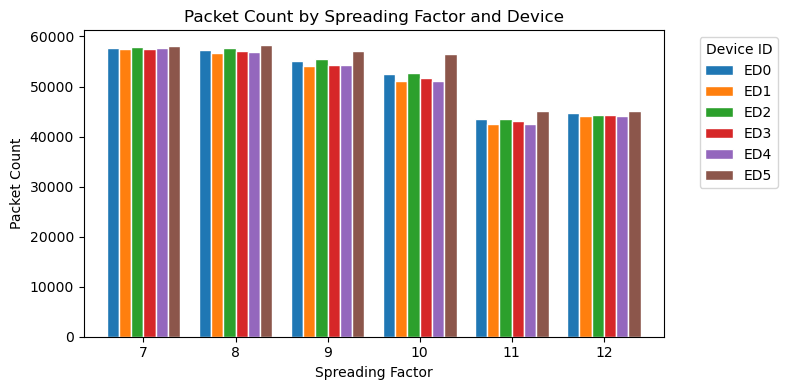

In [6]:
# Re‐pivot so SF is the index, devices are columns
grp = counts.pivot(index='SF', columns='device_id', values='count').fillna(0)

# Plot a grouped bar chart
ax = grp.plot(
    kind='bar',
    figsize=(8, 4),
    width=0.8,        # narrow the bars a bit
    edgecolor='w'
)

ax.set_xlabel('Spreading Factor')
ax.set_ylabel('Packet Count')
ax.set_title('Packet Count by Spreading Factor and Device')
ax.legend(title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

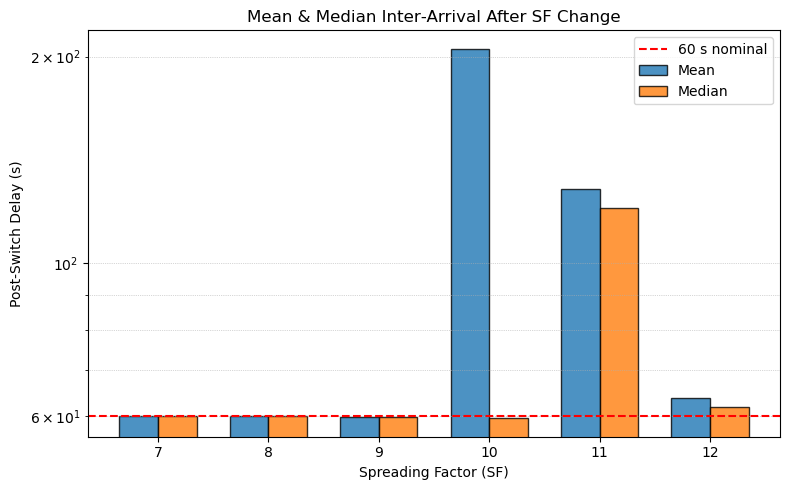

In [7]:
# Compute mean & median post‐switch delay per SF 
df = df.sort_values(['device_id','time'])
df['delta_s'] = df.groupby('device_id')['time'].diff().dt.total_seconds()

sf_changes = df[df['SF'] != df.groupby('device_id')['SF'].shift()]
first_after = (
    sf_changes
      .drop_duplicates(subset=['device_id','SF'])
      .loc[:, ['device_id','SF','delta_s']]
      .rename(columns={'delta_s': 'first_delta_s'})
)

grouped = first_after.groupby('SF')['first_delta_s']
means   = grouped.mean()
medians = grouped.median()

# Plot side‐by‐side mean & median bars 
sf_levels = means.index.astype(int).tolist()
x         = np.arange(len(sf_levels))
width     = 0.35

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(x - width/2, means.values,   width,
       label='Mean',   color='C0', edgecolor='k', alpha=0.8)
ax.bar(x + width/2, medians.values, width,
       label='Median', color='C1', edgecolor='k', alpha=0.8)

#  Add nominal‐interval reference
ax.axhline(60, color='red', linestyle='--', label='60 s nominal')

#  Formatting
ax.set_xticks(x)
ax.set_xticklabels([str(sf) for sf in sf_levels])
ax.set_xlabel('Spreading Factor (SF)')
ax.set_ylabel('Post‐Switch Delay (s)')
ax.set_title('Mean & Median Inter‐Arrival After SF Change')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', axis='y', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

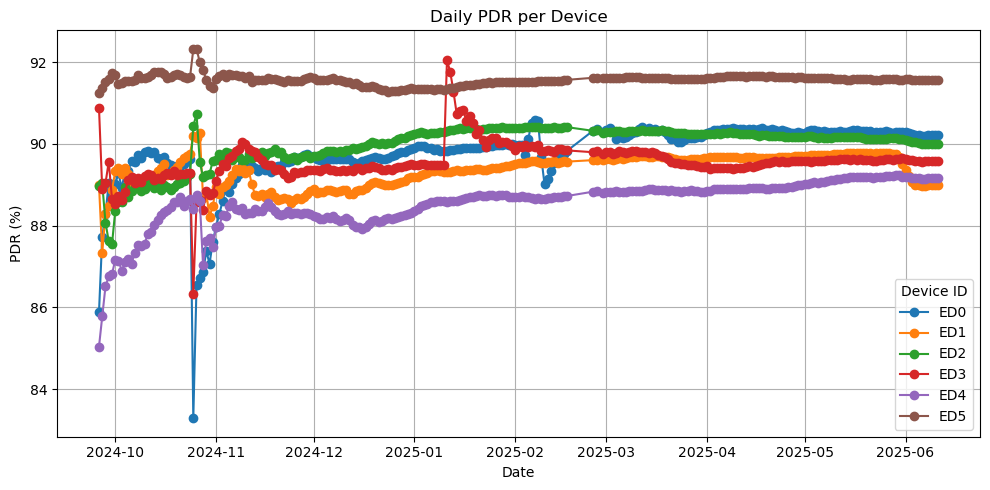

In [8]:
# Daily PDR
df['date'] = df['time'].dt.floor('D')
daily = (
    df
    .groupby(['device_id','date'])
    .agg(sent=('p_count','max'), recv=('f_count','max'))
    .assign(pdr=lambda x: x['recv']/x['sent']*100)
    .reset_index()
)

plt.figure(figsize=(10,5))
for dev, grp in daily.groupby('device_id'):
    plt.plot(grp['date'], grp['pdr'], marker='o', label=dev)
plt.title('Daily PDR per Device')
plt.ylabel('PDR (%)')
plt.xlabel('Date')
plt.legend(title='Device ID')
plt.grid(True)
plt.tight_layout()
plt.show()

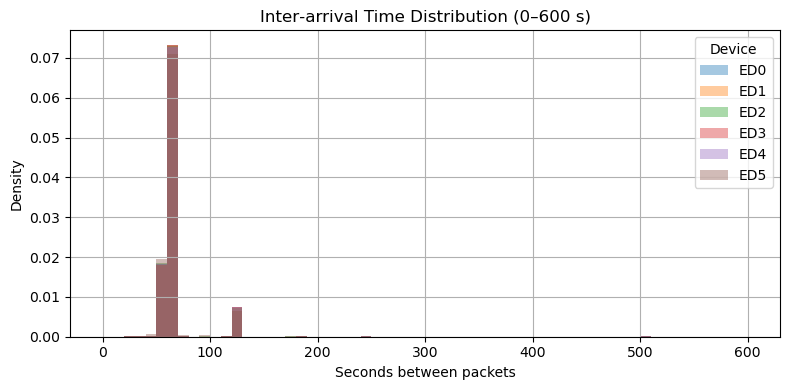

In [9]:
# Compute inter‐arrival (seconds) as before
df['delta_s'] = df.groupby('device_id')['time'].diff().dt.total_seconds()

# Plot only from 0 to, say, 600 s (10 min)
plt.figure(figsize=(8,4))
for dev, grp in df.groupby('device_id', observed=True):
    plt.hist(
        grp['delta_s'].dropna(),
        bins=60,
        range=(0,600),
        alpha=0.4,
        density=True,
        label=dev
    )
plt.title('Inter‐arrival Time Distribution (0–600 s)')
plt.xlabel('Seconds between packets')
plt.ylabel('Density')
plt.legend(title='Device')
plt.grid(True)
plt.tight_layout()
plt.show()

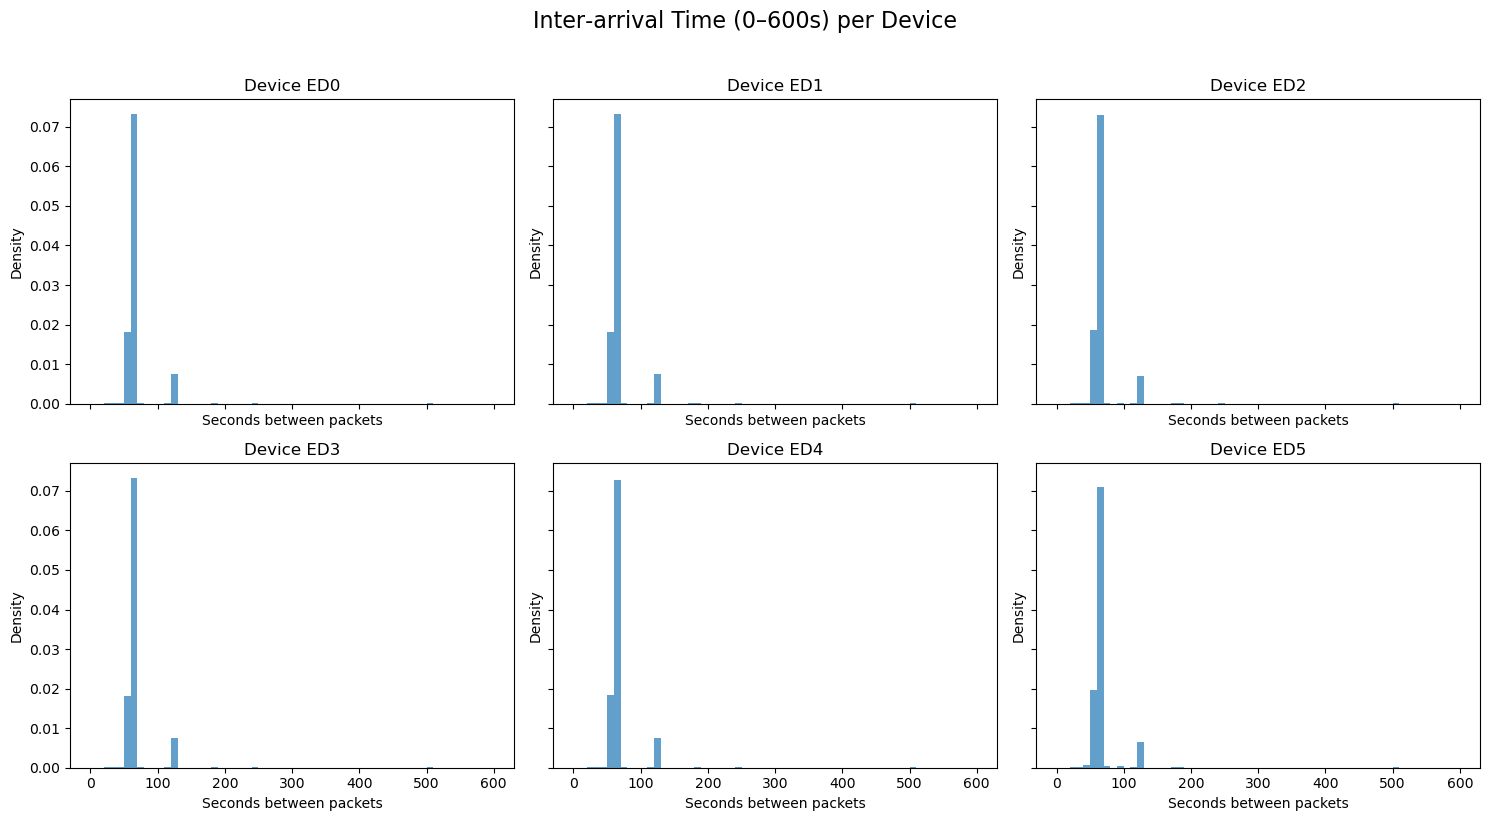

In [10]:
devices = df['device_id'].unique()
n = len(devices)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
axes = axes.flatten()

for ax, dev in zip(axes, devices):
    data = df.loc[df['device_id'] == dev, 'delta_s'].dropna()
    ax.hist(data, bins=60, range=(0,600), density=True, alpha=0.7)
    ax.set_title(f"Device {dev}")
    ax.set_xlabel('Seconds between packets')
    ax.set_ylabel('Density')

# turn off any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.suptitle('Inter‐arrival Time (0–600s) per Device', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


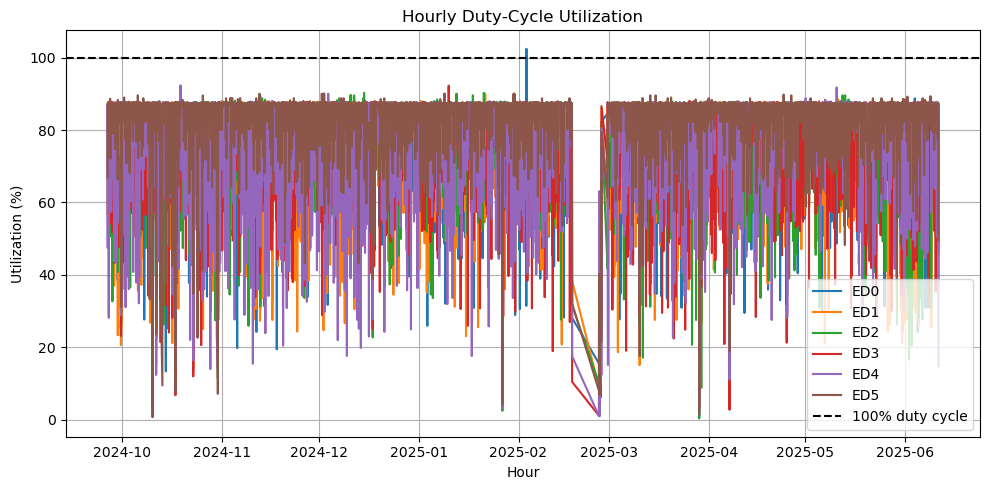

In [11]:
# Hourly duty‐cycle utilization
df['hour'] = df['time'].dt.floor('h')
hourly_toa = (
    df
    .groupby(['device_id','hour'])['toa']
    .sum()
    .reset_index()
    .assign(
        util_pct=lambda x: x['toa'] / (3600*0.01) * 100
    )
)

plt.figure(figsize=(10,5))
for dev, grp in hourly_toa.groupby('device_id'):
    plt.plot(grp['hour'], grp['util_pct'], label=dev)
plt.axhline(100, color='k', ls='--', label='100% duty cycle')
plt.title('Hourly Duty‐Cycle Utilization')
plt.ylabel('Utilization (%)')
plt.xlabel('Hour')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

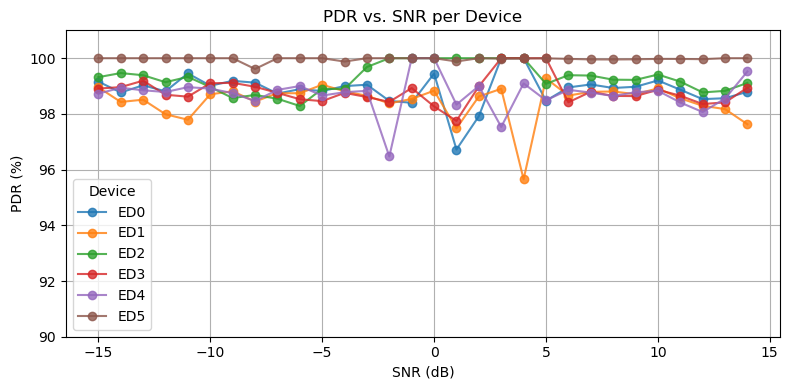

In [12]:
# Mark success by f_count increment = 1
df['success'] = df.groupby('device_id')['f_count'].diff().eq(1).fillna(True)

# Bin SNR
bins = np.arange(-15, 16, 1)
df['snr_bin'] = pd.cut(df['snr'], bins, right=False)

pdr_snr = (
    df.groupby(['device_id','snr_bin'], observed=True)['success']
      .agg(total='count', succ='sum')
      .assign(pdr=lambda x: x['succ']/x['total']*100)
      .reset_index()
)

# Plot
plt.figure(figsize=(8,4))
for dev, g in pdr_snr.groupby('device_id', observed=True):
    xs = [b.left for b in g['snr_bin']]
    plt.plot(xs, g['pdr'], '-o', alpha=0.8, label=dev)
plt.title('PDR vs. SNR per Device')
plt.xlabel('SNR (dB)')
plt.ylabel('PDR (%)')
plt.legend(title='Device')
plt.ylim(90, 101)
plt.grid(True)
plt.tight_layout()
plt.show()